In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'Cambria'

In [2]:
def generalise_x_matrix(x, degree):
    """
    Function for Generating Input Matrix (generalize for multivariate polynomial regression)
    """

    n_samples, n_features = x.shape
    features = [np.ones(n_samples)]

    # Generate polynomial features
    for d in range(1, degree + 1):
        current_degree_features = []

        # Generate features for each feature raised to the current degree
        for i in range(n_features):
            current_degree_features.append(x[:, i] ** d)

        # Generate interaction terms for current degree (if and only if d > 1)
        if d > 1:
            for i in range(n_features):
                for j in range(i + 1, n_features):  # Start from i + 1 to avoid self-interaction
                    interaction_term = (x[:, i] ** (d - 1)) * (x[:, j] ** 1)
                    current_degree_features.append(interaction_term)

        # Add current degree features to the main features list
        features.extend(current_degree_features)

    return np.column_stack(features)

In [3]:
def estimate_b(x, y):
    """
    Estimate Parameters Using OLS
    """
    return np.linalg.inv(x.T @ x) @ (x.T @ y)

In [4]:
def k_fold_cross_validation(x, y, k_func, degrees_func):
    """
    Function for k-fold cross-validation with random shuffling
    """

    # Shuffle the indices of the dataset randomly
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    fold_size = len(y) // k_func
    ssr_results_val = {degree: [] for degree in degrees_func}
    ssr_results_train = {degree: [] for degree in degrees_func}
    r2_results_train = {degree: [] for degree in degrees_func}
    r2_results_val = {degree: [] for degree in degrees_func}

    for degree in degrees_func:
        # Create polynomial features
        x_poly = generalise_x_matrix(x, degree)

        for fold in range(k_func):
            # Get validation indices for the current fold
            val_indices = indices[fold * fold_size: (fold + 1) * fold_size]

            # Get training indices as the remaining indices
            train_indices = np.setdiff1d(indices, val_indices)

            x_train, y_train = x_poly[train_indices], y[train_indices]
            x_val, y_val = x_poly[val_indices], y[val_indices]

            # Estimate parameters and predict
            b = estimate_b(x_train, y_train)
            y_pred_val = x_val @ b
            y_pred_train = x_train @ b

            # Calculate SSR for the validation and training set
            ssr_val = np.sum((y_val - y_pred_val) ** 2)
            ssr_results_val[degree].append(ssr_val)

            ssr_func_train = np.sum((y_train - y_pred_train) ** 2)
            ssr_results_train[degree].append(ssr_func_train)

            # Calculate R^2 for the validation and training set
            s_sy_train = np.sum((y_train - np.mean(y_train)) ** 2)
            r2_train = 1 - (ssr_func_train / s_sy_train)
            r2_results_train[degree].append(r2_train)

            s_sy_val = np.sum((y_val - np.mean(y_val)) ** 2)
            r2_val = 1 - (ssr_val / s_sy_val)
            r2_results_val[degree].append(r2_val)

    # Average SSR & R2 for each degree
    avg_ssr_val_func = {degree: np.mean(ssrs) for degree, ssrs in ssr_results_val.items()}
    avg_ssr_train_func = {degree: np.mean(ssrs) for degree, ssrs in ssr_results_train.items()}
    avg_r2_train_func = {degree: np.mean(r2s) for degree, r2s in r2_results_train.items()}
    avg_r2_val_func = {degree: np.mean(r2s) for degree, r2s in r2_results_val.items()}

    return avg_ssr_val_func, avg_ssr_train_func, avg_r2_val_func, avg_r2_train_func

In [5]:
# Load data
data = pd.read_csv('train.csv')
train_x = data['x'].to_numpy()
train_y = data['y'].to_numpy()

In [6]:
# Set seed for reproducibility
np.random.seed(60)

# Parameters for k-fold
k = 5
degrees = range(1, 23)

# Perform k-fold cross-validation
avg_ssr_val, avg_ssr_train, avg_r2_val, avg_r2_train = k_fold_cross_validation(train_x.reshape(-1, 1), train_y, k,
                                                                               degrees)

# Identify the best degree
best_degree = min(avg_ssr_val, key=avg_ssr_val.get)
print(f"Best polynomial degree: {best_degree}")

Best polynomial degree: 5


In [7]:
# Get the indices that would sort x
sorted_indices = np.argsort(train_x)
x_sorted = train_x[sorted_indices]
y_sorted = train_y[sorted_indices]

In [8]:
# Make Input Matrix
X_train = generalise_x_matrix(x_sorted.reshape(-1, 1), best_degree)

# Estimate Parameters For Training Data
B = estimate_b(X_train, y_sorted)
print("Estimated Parameters: ", B)

# Predict Outputs
pred_y_train = X_train @ B

Estimated Parameters:  [ 83.63591607   2.44833307  20.4101032  -10.82732749  -3.21687742
   0.57237938]


In [9]:
# SSR for Best degree
ssr_train = np.sum((pred_y_train - y_sorted) ** 2)
print(f'SSR: {ssr_train}')

# Save the parameters to a file
with open('3_weights.pkl', 'wb') as f:
    pickle.dump(B, f)

SSR: 235760.15949992897


In [10]:
# Load test data
test_data = pd.read_csv('test.csv')
test_x = test_data[['x']].to_numpy()
test_id = test_data['id'].to_numpy()

# Create polynomial features for test data
X_test = generalise_x_matrix(test_x, best_degree)

# Make predictions on the test set
test_predictions = X_test @ B

# Save test predictions to CSV
test_output = pd.DataFrame({'id': test_id, 'x': test_x.flatten(), 'y': test_predictions.flatten()})
test_output.to_csv('test_predictions.csv', index=False)

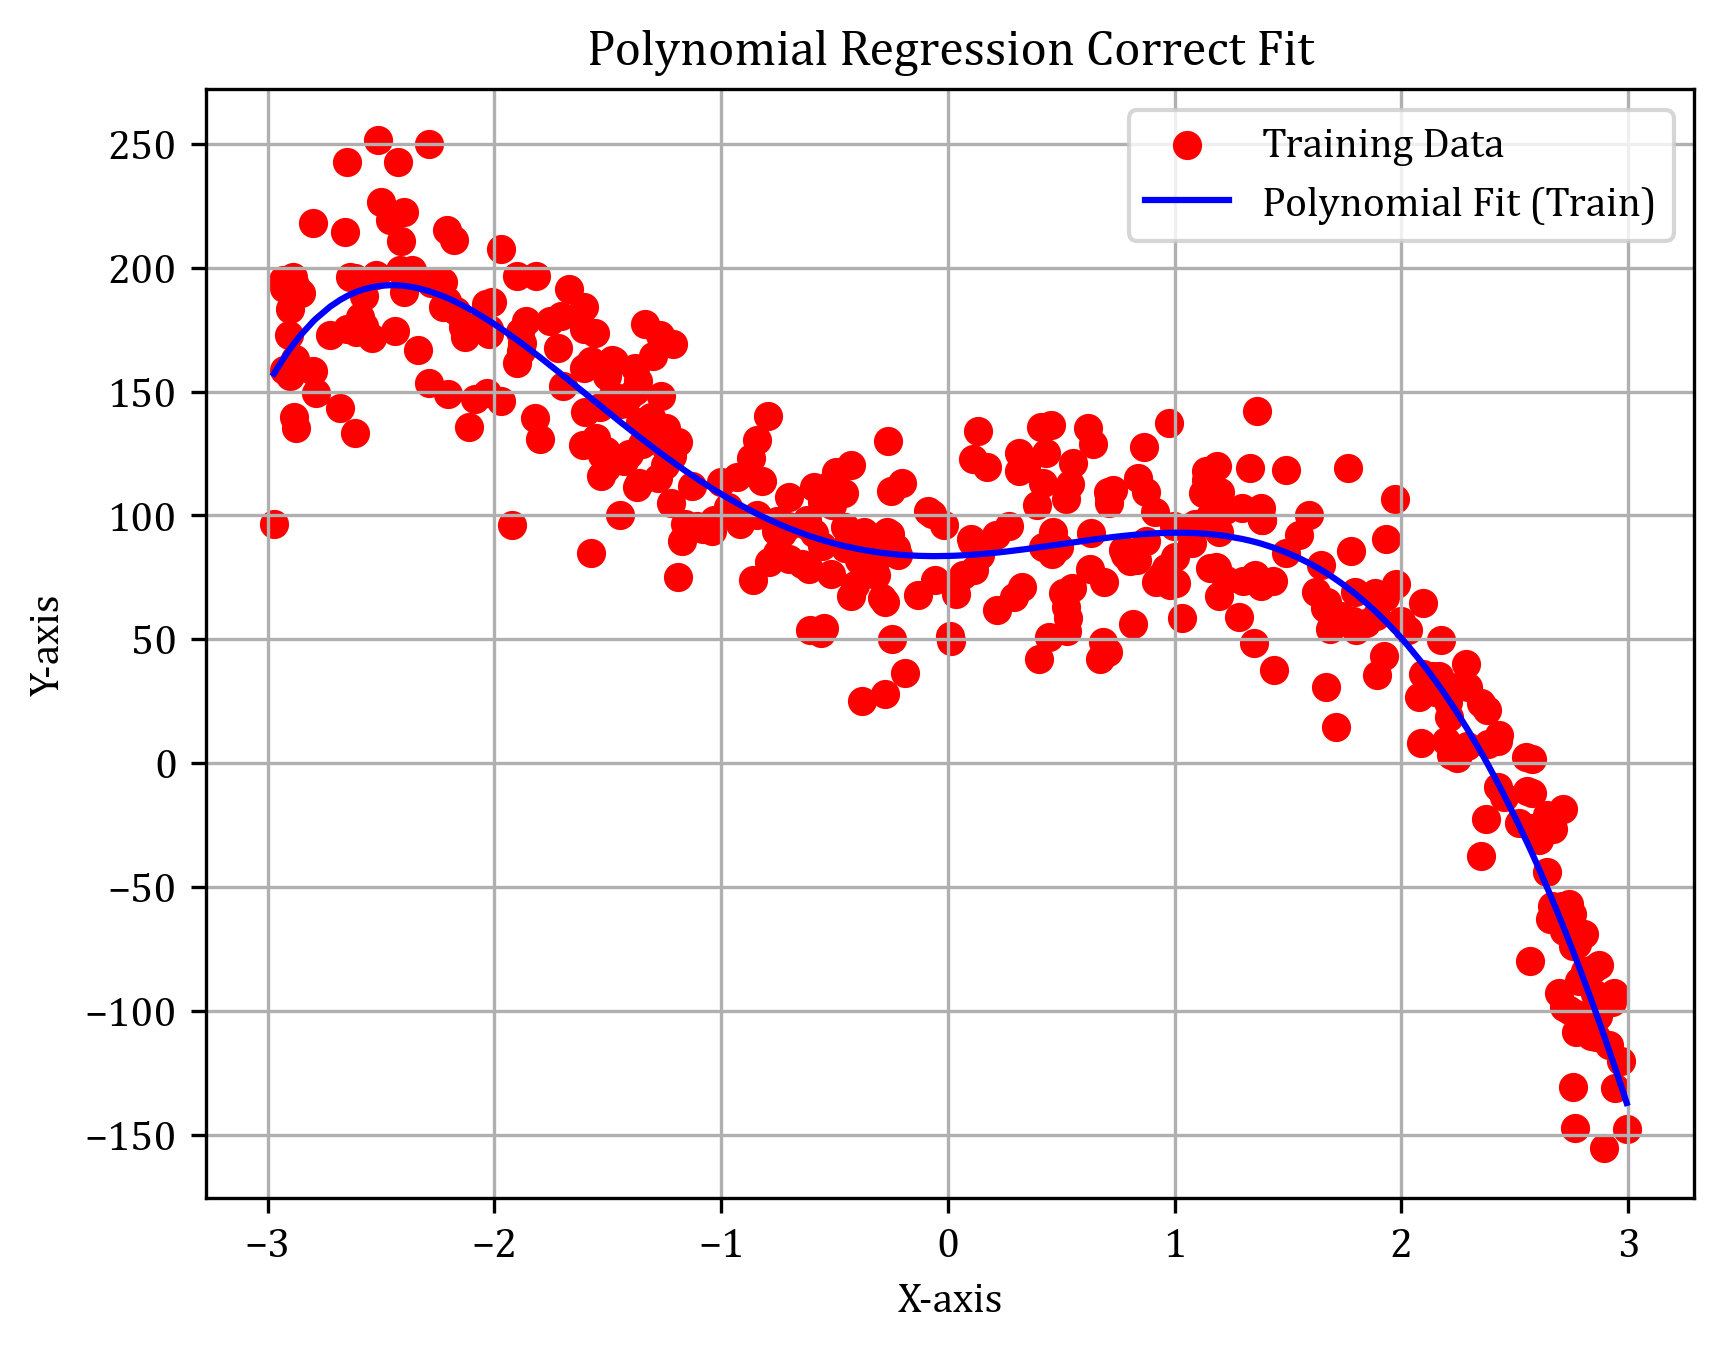

In [11]:
# Plotting Correct Polynomial fit
fig = plt.figure(dpi=300)
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_train, color='blue', label='Polynomial Fit (Train)')
plt.title('Polynomial Regression Correct Fit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()

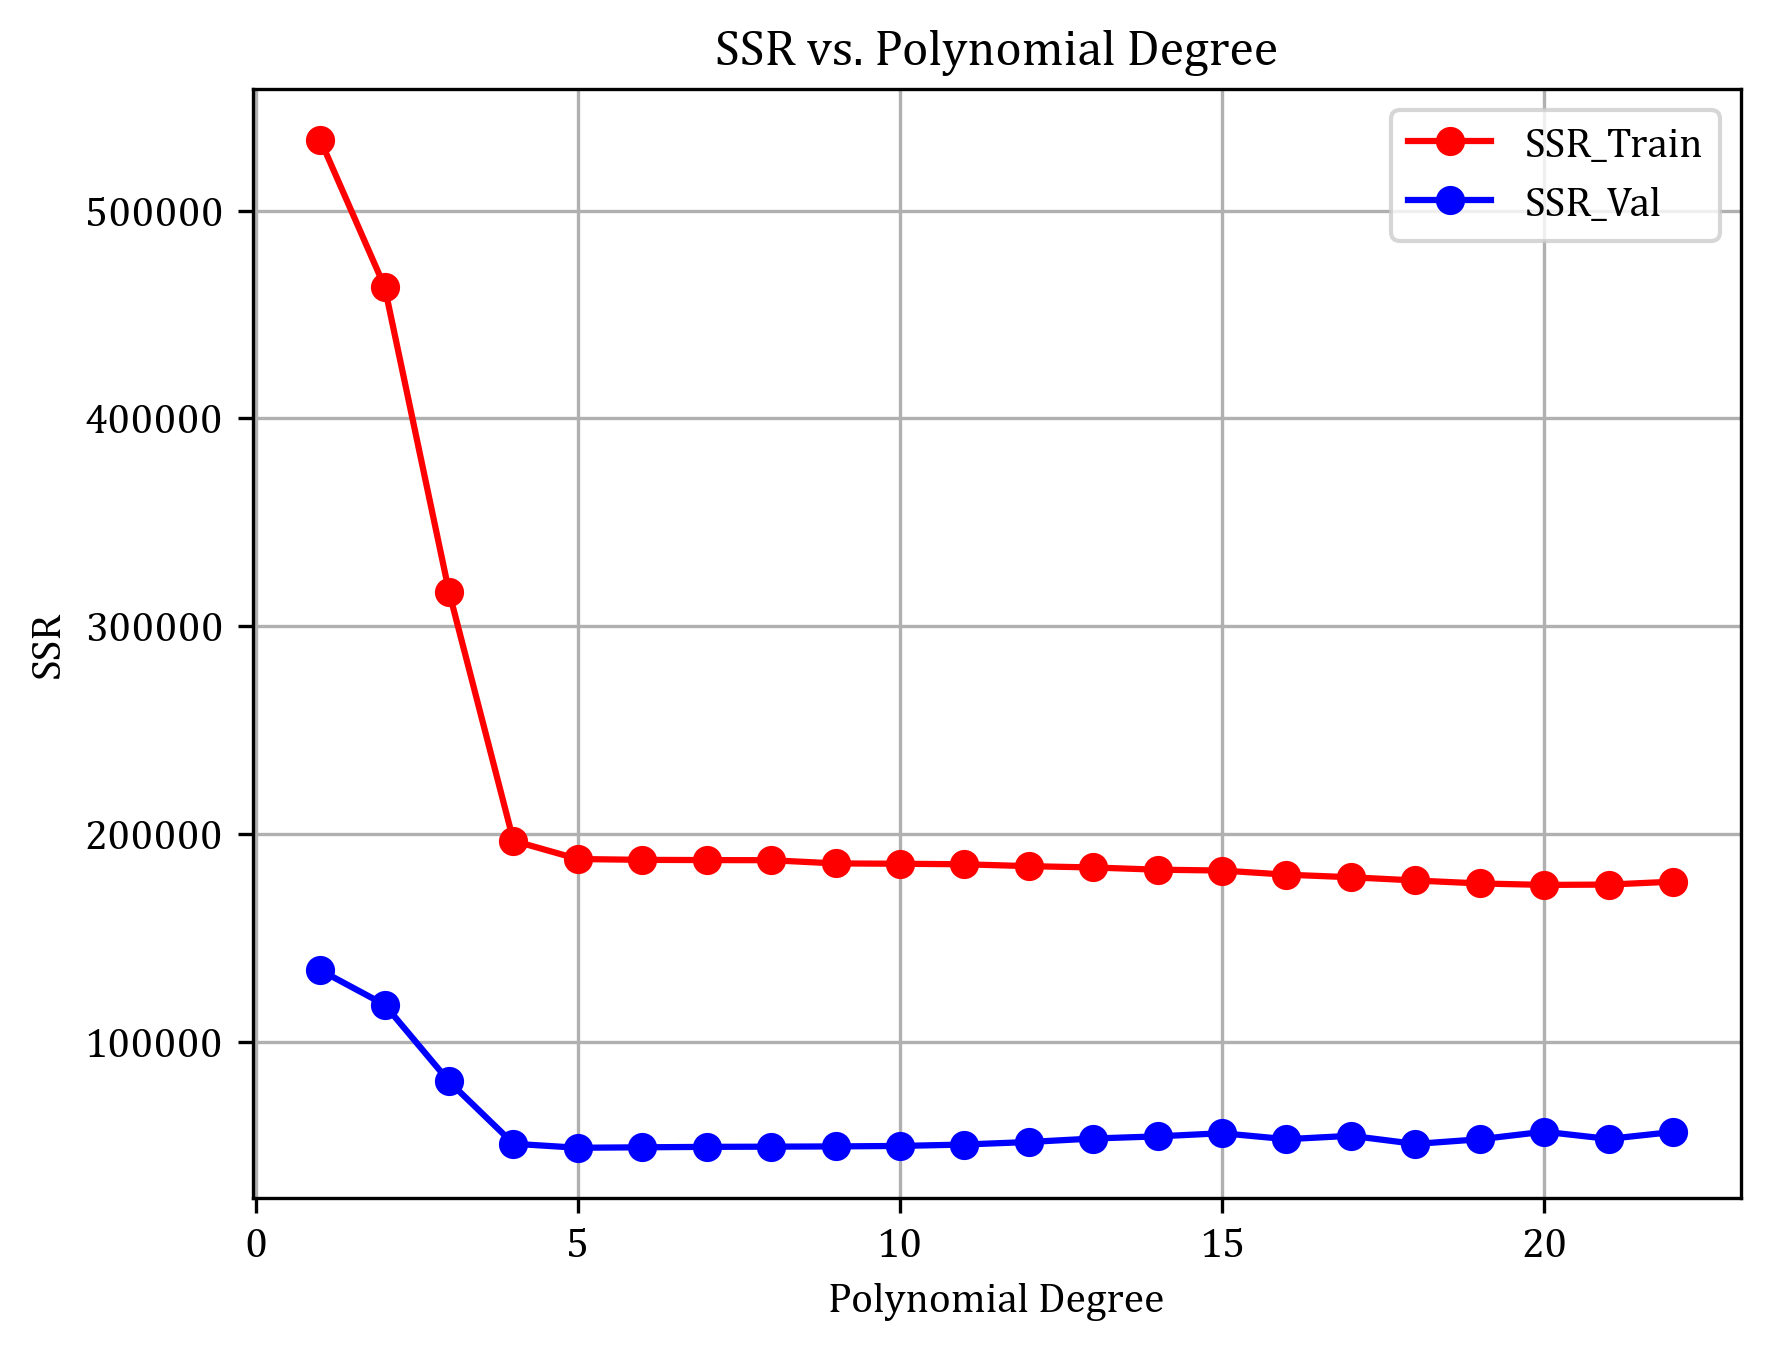

In [12]:
# Plotting of SSR
plt.figure(dpi=300)
plt.plot(degrees, list(avg_ssr_train.values()), marker='o', color='red', label='SSR_Train')
plt.plot(degrees, list(avg_ssr_val.values()), marker='o', color='blue', label='SSR_Val')
plt.title('SSR vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('SSR')
# plt.yscale('log')
plt.legend()
plt.grid()

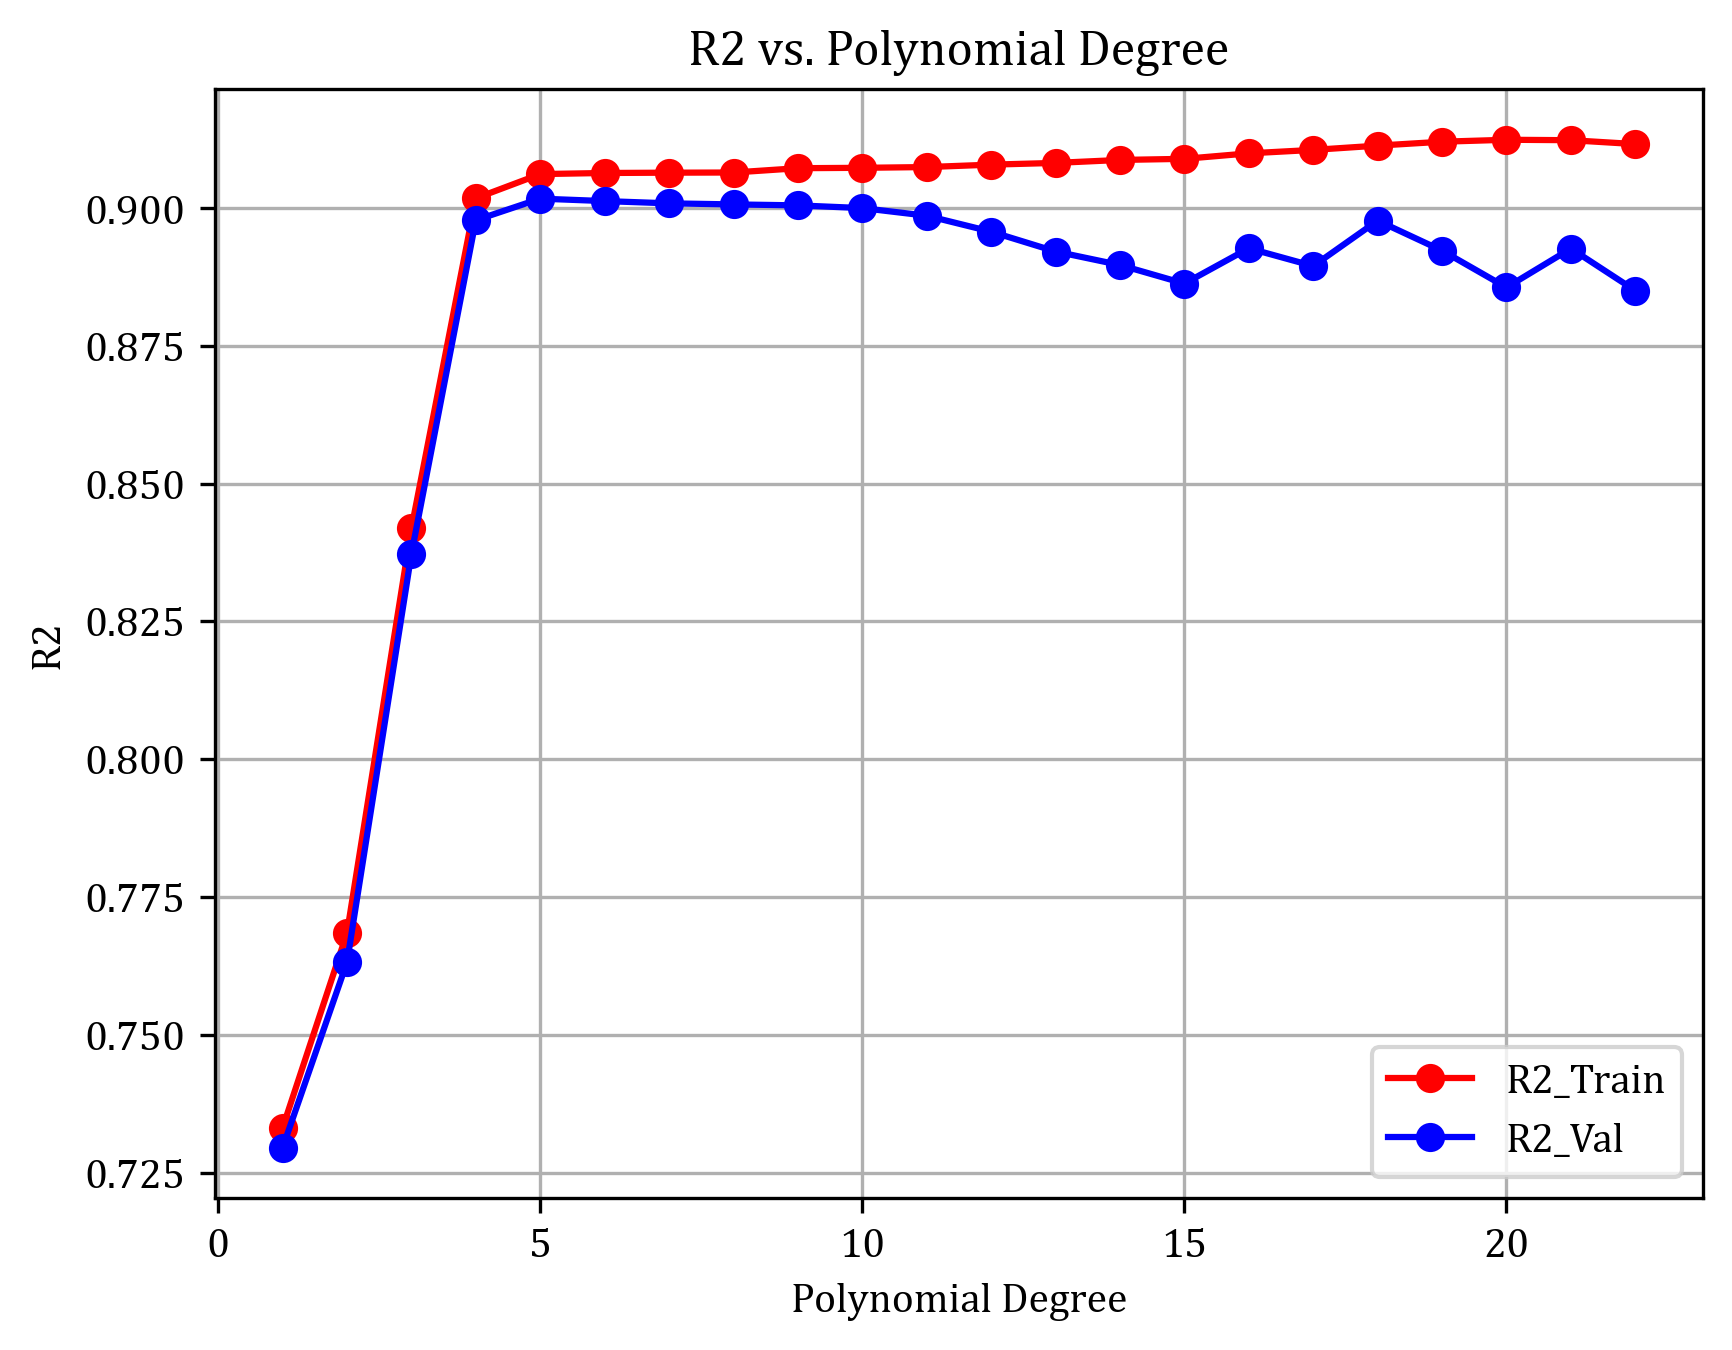

In [13]:
# Plotting of SSR
plt.figure(dpi=300)
plt.plot(degrees, list(avg_r2_train.values()), marker='o', color='red', label='R2_Train')
plt.plot(degrees, list(avg_r2_val.values()), marker='o', color='blue', label='R2_Val')
plt.title('R2 vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2')
plt.legend()
plt.grid()

In [14]:
#Underfit and Overfit
# R2 and SSR value for training set for degree 2 = min and max (other than degree 1) respectively (take 1-3 degree for underfit)
X_train_underfit = generalise_x_matrix(x_sorted.reshape(-1, 1), 2)
B_underfit = estimate_b(X_train_underfit, y_sorted)
pred_y_underfit = X_train_underfit @ B_underfit

# R2 and SSR value for training set for degree 20 is max and min respectively  
X_train_overfit = generalise_x_matrix(x_sorted.reshape(-1, 1), 20)
B_overfit = estimate_b(X_train_overfit, y_sorted)
pred_y_overfit = X_train_overfit @ B_overfit
print(np.sum((pred_y_overfit - y_sorted) ** 2))

222400.7261287558


In [15]:
# Plotting Underfit Polynomial fit
plt.figure(figsize=(18, 6), dpi=1000)
plt.subplot(1, 2, 1)
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_underfit, color='blue', label='Polynomial UnderFit')
plt.title('Polynomial Regression UnderFit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()

# Plotting Overfit Polynomial fit
plt.subplot(1, 2, 2)
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_overfit, color='blue', label='Polynomial OverFit')
plt.title('Polynomial Regression OverFit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()